Emma Klemets, Sept 26   
First look at the mapping data taken on Fri Sept 23rd, 2022

Note that the coordinate system of the fluxgates for these raw/corrected data files does not match the x,y,z position coordinates, but really:
> B1 = Bx   
  B2 = -Bz   
  B3 = By

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot as up
from stl import mesh
from mpl_toolkits import mplot3d
import pandas as pd
import sys, os

In [2]:
def staticCoordTransf(df):
    #corecting the coordinates from the FG coords to the normal MSR origin ones: y-> -z, z->y
    col_list = list(df)

    #swaps y and z
    col_list[7:10], col_list[10:13] = col_list[10:13], col_list[7:10]
    df.columns = col_list

    #applies the -ive sign
    df[col_list[10:13]] = df[col_list[10:13]].apply(lambda x: -1*x)
    
    return df

In [3]:
#data in muT and cm
dfRed = pd.read_csv('Sept23_data/20220923_153158_Red_RUN1.csv')
dfRed['datetime'] = pd.to_datetime(dfRed['datetime'], format='%Y%m%d_%H%M%S')

dfGreen = pd.read_csv('Sept23_data/20220923_170313_Green_RUN3.csv')
dfGreen['datetime'] = pd.to_datetime(dfGreen['datetime'], format='%Y%m%d_%H%M%S')

dfRedSta = pd.read_csv('Sept23_data/20220923_153207_Red.csv')
dfRedSta['Datetime'] = pd.to_datetime(dfRedSta['Datetime'], format='%Y%m%d_%H%M%S')
dfRedSta = staticCoordTransf(dfRedSta)

dfGreenSta = pd.read_csv('Sept23_data/20220923_165751_Green.csv')
dfGreenSta['Datetime'] = pd.to_datetime(dfGreenSta['Datetime'], format='%Y%m%d_%H%M%S')
dfGreenSta = staticCoordTransf(dfGreenSta)


In [4]:
def returnVals(data, xrange, yrange, zrange):
    
    x=data['x'].to_numpy()
    y=data['y'].to_numpy()
    z=data['z'].to_numpy()
    Bx=data['B1'].to_numpy()
    By=data['B3'].to_numpy()
    Bz=-data['B2'].to_numpy()
    
    if isinstance(xrange, list):
        xbounds = np.where((x >= xrange[0]) & (x <= xrange[1]))

        xbounds = np.where((x >= xrange[0]) & (x <= xrange[1]))
        ybounds = np.where((y >= yrange[0]) & (y <= yrange[1]))
        zbounds = np.where((z >= zrange[0]) & (z <= zrange[1]))

        allIn = [i for i in xbounds[0] if (i in ybounds[0]) & (i in zbounds[0])]
        
    else:
        allIn = True
    
    return x[allIn], y[allIn], z[allIn], Bx[allIn], By[allIn], Bz[allIn]

## First the red board configuration

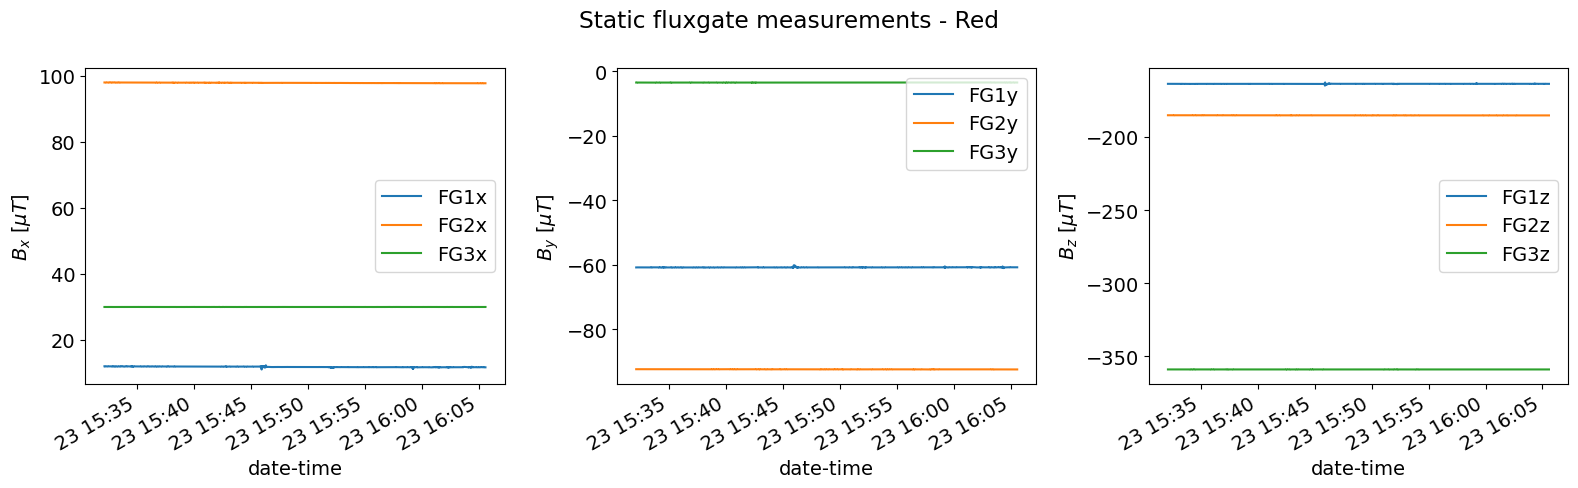

In [5]:
plt.rcParams['font.size'] = '14'

fig, axs = plt.subplots(1, 3, figsize=(16,5))
plt.suptitle("Static fluxgate measurements - Red")
# \n fluxgate coords (so y=-z, z=y)

q = list(dfRedSta.filter(like='x').columns)
q.append('Datetime')
dfRedSta.filter(items=q).plot(ax=axs[0], x=q[-1], y=q[:3])

q = list(dfRedSta.filter(like='y').columns)
q.append('Datetime')
# print(q[:3])
dfRedSta.filter(items=q).plot(ax=axs[1], x=q[-1], y=np.array(q[:3]))

q = list(dfRedSta.filter(like='z').columns)
q.append('Datetime')
dfRedSta.filter(items=q).plot(ax=axs[2], x=q[-1], y=q[:3])

axs[0].set_ylabel('$B_x$ [$\mu T$]')
axs[0].set_xlabel('date-time')

axs[1].set_ylabel('$B_y$ [$\mu T$]')
axs[1].set_xlabel('date-time')

axs[2].set_ylabel('$B_z$ [$\mu T$]')
axs[2].set_xlabel('date-time')

plt.tight_layout()
plt.savefig(f'plots/static_red.pdf', bbox_inches='tight')
plt.show()

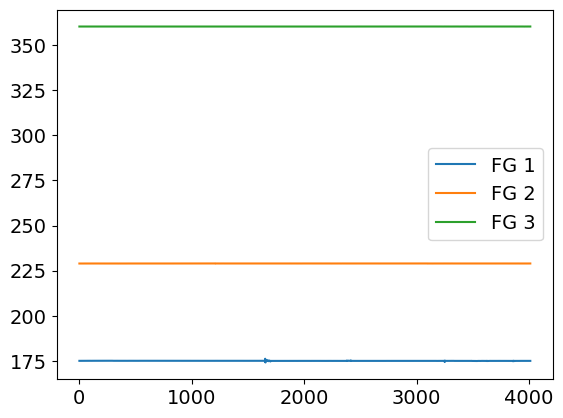

In [6]:
def Mag(x, y, z):
    return np.sqrt(x**2 + y**2 + z**2)

plt.plot(Mag(dfRedSta['FG1x'], dfRedSta['FG1y'], dfRedSta['FG1z'] ), label="FG 1")
plt.plot(Mag(dfRedSta['FG2x'], dfRedSta['FG2y'], dfRedSta['FG2z'] ), label='FG 2')
plt.plot(Mag(dfRedSta['FG3x'], dfRedSta['FG3y'], dfRedSta['FG3z'] ), label='FG 3')
plt.legend()
plt.show()

C:\Users\Emma\AppData\Local\Temp\ipykernel_37200\4114787563.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = mplot3d.Axes3D(fig)


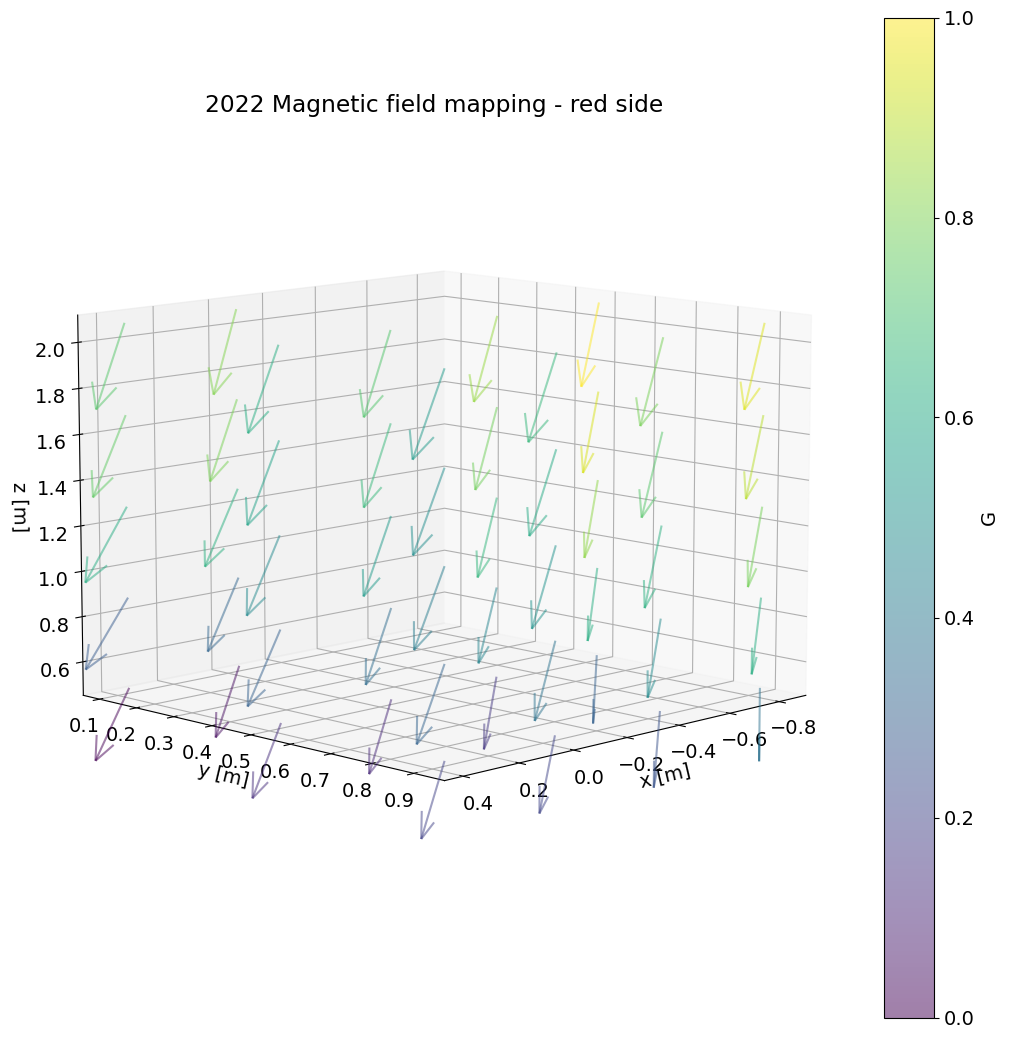

In [7]:
fig = plt.figure(figsize=(10, 10))
axes = mplot3d.Axes3D(fig)

# axes.set_title("Electric Field for bias of 800 V", pad=-10)
plt.title("2022 Magnetic field mapping - red side", pad=-10)

x,y,z,Bx,By,Bz = returnVals(dfRed, 'no', [-200, 200], [-200, 200], )
c = np.sqrt(Bx**2+By**2+Bz**2)

# """
# Flatten and normalize
c = (c.ravel() - c.min()) / c.ptp()
# # Repeat for each body line and two head lines
c = np.concatenate((c, np.repeat(c, 2)))

c = plt.cm.viridis(c)
Q = axes.quiver(x/100,y/100,z/100, Bx,By,Bz, colors=c, length=.4, normalize=True, alpha=0.5)
cbar = fig.colorbar(Q, label="G")
    
axes.view_init(elev=10., azim=45)

axes.set_xlabel('x [m]')
axes.set_ylabel('y [m]')
axes.set_zlabel('z [m]')

plt.show()

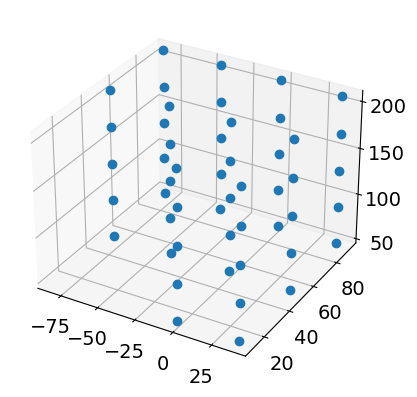

In [24]:
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1, projection='3d')
ax1.plot(dfRed['x'], dfRed['y'], dfRed['z'], linestyle='', label=None, marker='o')

## Now green board configuration

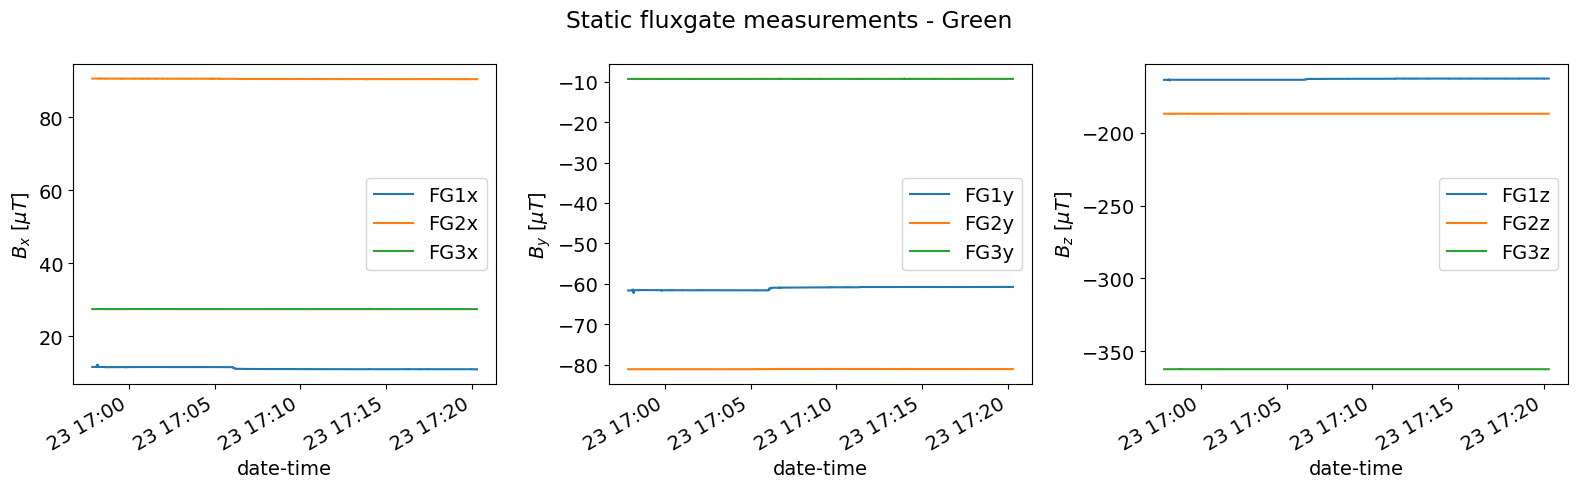

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(16,5))
plt.suptitle("Static fluxgate measurements - Green")

q = list(dfGreenSta.filter(like='x').columns)
q.append('Datetime')
dfGreenSta.filter(items=q).plot(ax=axs[0], x=q[-1], y=q[:3])

q = list(dfGreenSta.filter(like='y').columns)
q.append('Datetime')
dfGreenSta.filter(items=q).plot(ax=axs[1], x=q[-1], y=q[:3])

q = list(dfGreenSta.filter(like='z').columns)
q.append('Datetime')
dfGreenSta.filter(items=q).plot(ax=axs[2], x=q[-1], y=q[:3])

axs[0].set_ylabel('$B_x$ [$\mu T$]')
axs[0].set_xlabel('date-time')

axs[1].set_ylabel('$B_y$ [$\mu T$]')
axs[1].set_xlabel('date-time')

axs[2].set_ylabel('$B_z$ [$\mu T$]')
axs[2].set_xlabel('date-time')

plt.tight_layout()
plt.savefig(f'plots/static_green.pdf', bbox_inches='tight')
plt.show()

C:\Users\Emma\AppData\Local\Temp\ipykernel_37200\1318313601.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = mplot3d.Axes3D(fig)


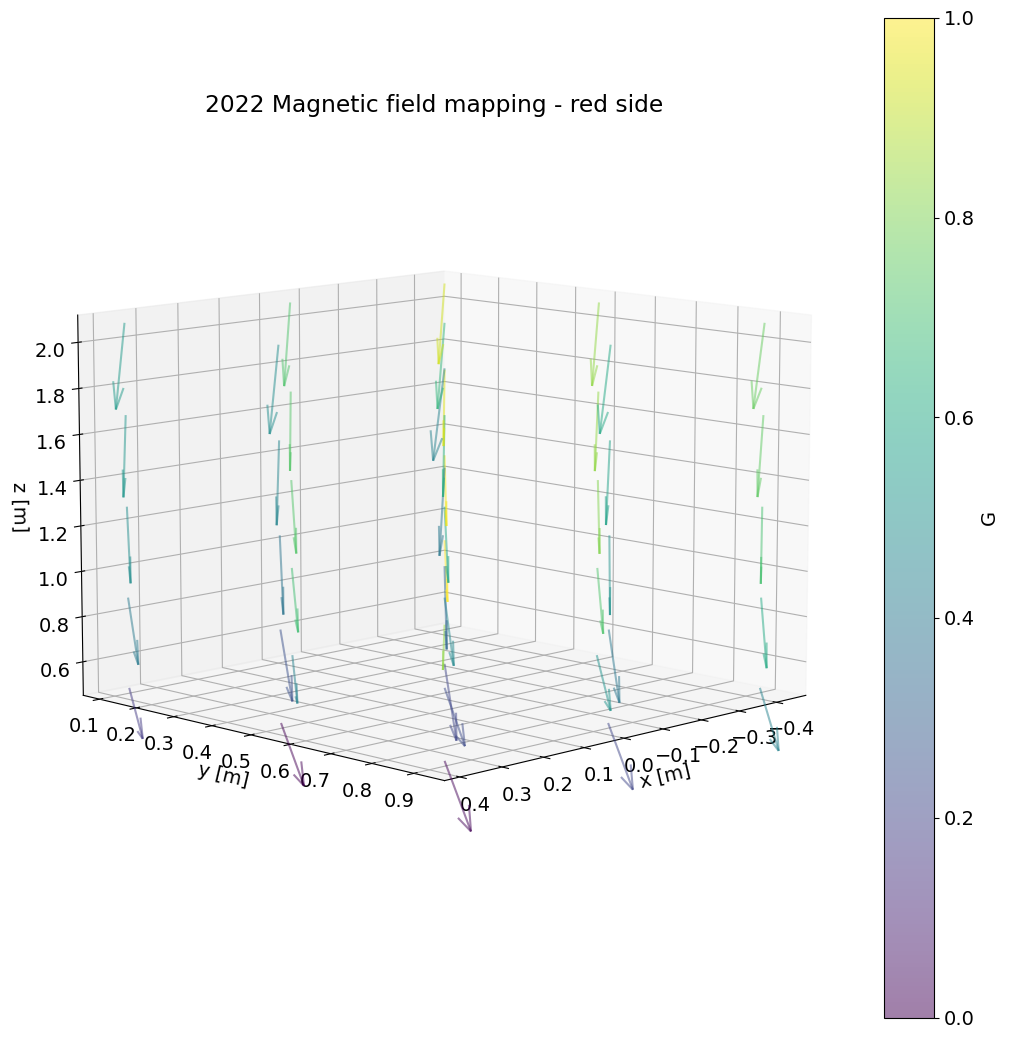

In [9]:
fig = plt.figure(figsize=(10, 10))
axes = mplot3d.Axes3D(fig)

# axes.set_title("Electric Field for bias of 800 V", pad=-10)
plt.title("2022 Magnetic field mapping - red side", pad=-10)

x,y,z,Bx,By,Bz = returnVals(dfGreen, 'no', [-200, 200], [-200, 200], )
c = np.sqrt(Bx**2+By**2+Bz**2)

# """
# Flatten and normalize
c = (c.ravel() - c.min()) / c.ptp()
# # Repeat for each body line and two head lines
c = np.concatenate((c, np.repeat(c, 2)))

c = plt.cm.viridis(c)
Q = axes.quiver(x/100,y/100,z/100, Bx,By,Bz, colors=c, length=.4, normalize=True, alpha=0.5)
cbar = fig.colorbar(Q, label="G")
    
axes.view_init(elev=10., azim=45)

axes.set_xlabel('x [m]')
axes.set_ylabel('y [m]')
axes.set_zlabel('z [m]')

plt.show()

## Stairs data
uncorrected for offsets rn

In [10]:
#data in muT and cm
dfStair = pd.read_csv('Sept23_data/20220926_164800_RUN5.csv')
dfStair['datetime'] = pd.to_datetime(dfStair['datetime'], format='%Y%m%d_%H%M%S')

dfStairSta = pd.read_csv('Sept23_data/20220926_160856_platform_RUN5.csv')
dfStairSta['Datetime'] = pd.to_datetime(dfStairSta['Datetime'], format='%Y%m%d_%H%M%S')
dfStairSta = staticCoordTransf(dfStarirsSta)

NameError: name 'dfStarirsSta' is not defined

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(16,5))
plt.suptitle("Static fluxgate measurements - Stairs")

q = list(dfStairSta.filter(like='x').columns)
q.append('Datetime')
dfStairSta.filter(items=q).plot(ax=axs[0], x=q[-1], y=q[:3])

q = list(dfStairSta.filter(like='y').columns)
q.append('Datetime')
dfStairSta.filter(items=q).plot(ax=axs[1], x=q[-1], y=q[:3])

q = list(dfStairSta.filter(like='z').columns)
q.append('Datetime')
dfStairSta.filter(items=q).plot(ax=axs[2], x=q[-1], y=q[:3])

axs[0].set_ylabel('$B_x$ [$\mu T$]')
axs[0].set_xlabel('date-time')

axs[1].set_ylabel('$B_y$ [$\mu T$]')
axs[1].set_xlabel('date-time')

axs[2].set_ylabel('$B_z$ [$\mu T$]')
axs[2].set_xlabel('date-time')

plt.tight_layout()
plt.savefig(f'plots/static_stairs.pdf', bbox_inches='tight')
plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 10))
axes = mplot3d.Axes3D(fig)

# axes.set_title("Electric Field for bias of 800 V", pad=-10)
plt.title("2022 Magnetic field mapping - stairs", pad=-10)

x,y,z,Bx,By,Bz = returnVals(dfStair, 'no', [-200, 200], [-200, 200], )
c = np.sqrt(Bx**2+By**2+Bz**2)

# """
# Flatten and normalize
c = (c.ravel() - c.min()) / c.ptp()
# # Repeat for each body line and two head lines
c = np.concatenate((c, np.repeat(c, 2)))

c = plt.cm.viridis(c)
Q = axes.quiver(x/100,y/100,z/100, Bx,By,Bz, colors=c, length=.4, normalize=True, alpha=0.5)
cbar = fig.colorbar(Q, label="G")
    
axes.view_init(elev=10., azim=45)

axes.set_xlabel('x [m]')
axes.set_ylabel('y [m]')
axes.set_zlabel('z [m]')

plt.show()

### Offset for stairs

In [ ]:
u0 = 4*np.pi*1e-7 #T m/A

def B(n, I, R):
    return ((4/5)**(3/2) * u0 *n*I/R ) *1e6 #uT



In [ ]:
B(15, 0.7, .6)

## Comparing orginal data points taken between the old 2019 data and the new data

In [80]:
#2019 data
path = "../MagMapping-export_TH_2019/"

df1 = pd.read_csv(f'{path}Mapping_0809_RUN1.csv')
df2 = pd.read_csv(f'{path}Mapping_0809_RUN2.csv')
df3 = pd.read_csv(f'{path}Mapping_0809_RUN3.csv')
df4 = pd.read_csv(f'{path}Mapping_0809_RUN4.csv')

df_all0 = df1.append(df2)
df_all1  = df_all0.append(df3)
df_all  = df_all1.append(df4)

shift_toMSR = [51.7,  0.,  16.3] #cm

df_all['x'] = - df_all.u + 10.25 +shift_toMSR[0]
df_all['y'] = -df_all.w +shift_toMSR[0]
df_all['z'] = df_all.v -1.25 + 188.1 -275  +shift_toMSR[0]#-> sets z = 0 to the center of the MSR 
# -1.25cm accounts for the position of the sensing center of the probe and the marker on the probe. 
# + 188.1cm: from z=0 of the measurement to the floor, -275cm: from the floor to the planned center of MSR
# df_all['z'] = df_all.v -1.25 ## previous version

df_all['B_x'] = -df_all['B_u']
df_all['B_y'] = -df_all['B_w']
df_all['B_z'] = -df_all['B_v']  

C:\Users\Emma\AppData\Local\Temp\ipykernel_37200\1859570859.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all0 = df1.append(df2)
C:\Users\Emma\AppData\Local\Temp\ipykernel_37200\1859570859.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all1  = df_all0.append(df3)
C:\Users\Emma\AppData\Local\Temp\ipykernel_37200\1859570859.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all  = df_all1.append(df4)


In [81]:
dfRed_cor = pd.read_csv('Sept23_data/20220923_153158_Red_RUN1_cor.csv')
dfRed_cor['datetime'] = pd.to_datetime(dfRed_cor['datetime'], format='%Y%m%d_%H%M%S')

dfGreen_cor = pd.read_csv('Sept23_data/20220923_170313_Green_RUN3_cor.csv')
dfGreen_cor['datetime'] = pd.to_datetime(dfGreen_cor['datetime'], format='%Y%m%d_%H%M%S')

In [82]:
# dfRed_cor = dfRed
L_red = np.array([ 813.5939,   -1636.6933,  751.818])/10 #cm

dfRed_cor['x'] = dfRed_cor.x +L_red[0]
dfRed_cor['y'] = dfRed_cor.y+L_red[1]
dfRed_cor['z'] = dfRed_cor.z +L_red[2]-275

# dfGreen_cor = dfGreen
    #reference point used (L), relative to center of MSR (but z of this origin was on the floor)
L_green = np.array([-812.072,    -1635.7079 , 751.7235])/10 #cm
    
dfGreen_cor['x'] = dfGreen_cor.x +L_green[0]
dfGreen_cor['y'] = dfGreen_cor.y+L_green[1]
dfGreen_cor['z'] = dfGreen_cor.z +L_green[2]-275

# df_new_all  = dfRed_cor.append(dfGreen_cor)

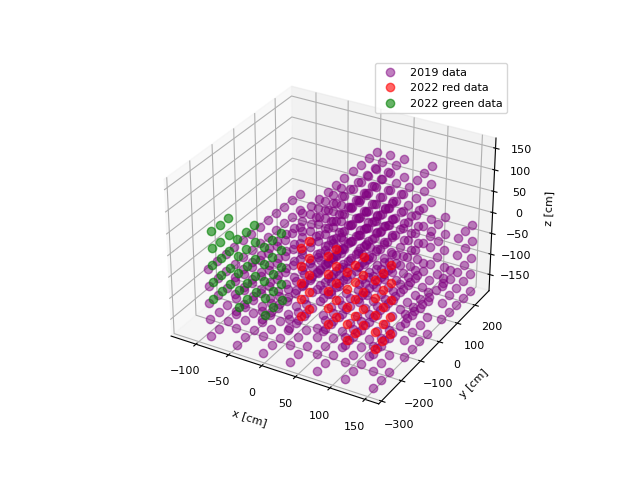

In [114]:
%matplotlib widget

fig = plt.figure()
ax1 = fig.add_subplot(1,1,1, projection='3d')
ax1.plot(df_all['x'], df_all['y'], df_all['z'], linestyle=' ', label='2019 data', marker='o', color='purple', alpha=0.5)

ax1.plot(dfRed_cor['x'], dfRed_cor['y'], dfRed_cor['z'], linestyle='', 
         label='2022 red data', marker='o', color='r', alpha=0.6)
ax1.plot(dfGreen_cor['x'], dfGreen_cor['y'], dfGreen_cor['z'], linestyle='', 
         label='2022 green data', marker='o', color='g', alpha=0.6)

# ax1.view_init(elev=27, azim=106)
ax1.legend()

ax1.set_xlabel('x [cm]')
ax1.set_ylabel('y [cm]')
ax1.set_zlabel('z [cm]')

plt.show()

In [95]:
from matplotlib import animation
# from mpl_toolkits.mplot3d import Axes3D

def init():
    ax.view_init(elev=10., azim=0)
    return [scat]


def animate(i):
    ax.view_init(elev=10., azim=i)
    return [scat]

# Create an init function and the animate functions.
# Both are explained in the tutorial. Since we are changing
# the the elevation and azimuth and no objects are really
# changed on the plot we don't have to return anything from
# the init and animate function. (return value is explained
# in the tutorial.

In [106]:
# fig = plt.figure()
# ax1 = Axes3D(fig)
# ax1.plot(df_all['x'], df_all['y'], df_all['z'], linestyle='', label=None, marker='o')

# ax1.plot(dfRed_cor['x'], dfRed_cor['y'], dfRed_cor['z'], linestyle='', label=None, marker='o', color='r')
# ax1.plot(dfGreen_cor['x'], dfGreen_cor['y'], dfGreen_cor['z'], linestyle='', label=None, marker='o', color='g')

# ax1.set_xlabel('x [cm]')
# ax1.set_ylabel('y [cm]')
# ax1.set_zlabel('z [cm]')

# def randrange(n, vmin, vmax):
#     return (vmax - vmin) * np.random.rand(n) + vmin


# n = 100
# xx = randrange(n, 23, 32)
# yy = randrange(n, 0, 100)
# zz = randrange(n, -50, -25)

# # Create a figure and a 3D Axes
# fig = plt.figure()
# ax = Axes3D(fig)
# scat = ax.scatter(xx, yy, zz, marker='o', s=20, c="goldenrod", alpha=0.6)

# # Animate
# anim = animation.FuncAnimation(fig, animate, init_func=init,
#                                frames=360, interval=30, blit=True)
# # Save
# anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

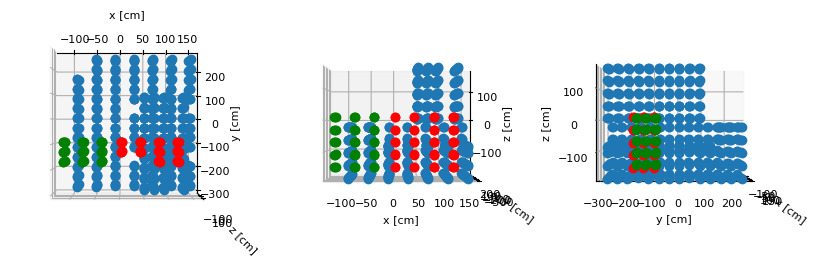

In [94]:
%matplotlib inline
plt.rcParams['font.size'] = '8'

fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot(1,3,1, projection='3d')
ax2 = plt.subplot(1,3,2, projection='3d')
ax3 = plt.subplot(1,3,3, projection='3d')
axes = [ax1, ax2, ax3]

for ax in axes:
    ax.plot(df_all['x'], df_all['y'], df_all['z'], linestyle='', label=None, marker='o')

    ax.plot(dfRed_cor['x'], dfRed_cor['y'], dfRed_cor['z'], linestyle='', label=None, marker='o', color='r')
    ax.plot(dfGreen_cor['x'], dfGreen_cor['y'], dfGreen_cor['z'], linestyle='', label=None, marker='o', color='g')
    ax.set_xlabel('x [cm]')
    ax.set_ylabel('y [cm]')
    ax.set_zlabel('z [cm]')
  
ax1.view_init(elev=90, azim=-90)
ax2.view_init(elev=0., azim=-90)
ax3.view_init(elev=0., azim=0)

plt.show()